In [57]:
from operator import truediv

from anyio.lowlevel import checkpoint
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver

In [58]:
load_dotenv()

True

In [59]:
from langgraph.graph.message import add_messages

class ChatState(TypedDict):

    messages: Annotated[list[BaseMessage], add_messages]

In [60]:
llm = ChatOpenAI()


def chat_node(state: ChatState):

    # take user query from state
    messages = state['messages']

    # send to llm
    response = llm.invoke(messages)

    # response store state
    return {'messages': [response]}

In [61]:
checkpointer = MemorySaver()

graph = StateGraph(ChatState)

# add nodes
graph.add_node('chat_node', chat_node)

graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)

chatbot = graph.compile(checkpointer=checkpointer)

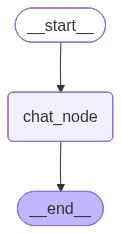

In [62]:
chatbot

In [63]:
initial_state = {
    'messages': [HumanMessage(content='What is the capital of india')]
}

In [64]:
thread_id = '1'

while True:
    user_message = input('Type a message: ')
    print('user message:', user_message)

    if user_message.strip().lower() in ['exit', 'quit', 'bye']:
        break

    config = {'configurable': {'thread_id': thread_id}}
    response = chatbot.invoke({'messages': [HumanMessage(content=user_message)]}, config=config)
    print('AI:', response['messages'][-1].content)

user message: Hi my name is Ravi, whats your name?
AI: Hello Ravi, I am an AI assistant. How can I assist you today?
user message: AI assistant please tell me my name
AI: Your name is Ravi.
user message: exit
